Imports & settings

In [28]:
# Cell 0 — Imports & settings
import os
import numpy as np
import pandas as pd
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# Optional for fast post-hoc Dunn
try:
    import scikit_posthocs as sp
    HAS_SP = True
except Exception:
    HAS_SP = False

# Create output dirs
os.makedirs("../reports/figures", exist_ok=True)


In [29]:
# Cell 1 — Load / check data (defensive)
# This notebook expects either 'combined' DataFrame in the environment
# or 'df' (raw underwriting rows) from which we will compute policy-aggregates.

if 'combined' in globals():
    print("Using existing 'combined' DataFrame.")
elif 'df' in globals():
    print("No 'combined' found — will build from 'df'.")
else:
    # try to load a raw file if exists (txt/csv)
    candidate = "../data/raw/MachineLearningRating_v3.txt"
    if os.path.exists(candidate):
        # attempt to auto-detect separators
        seps = [",","|","\t",";"]
        for s in seps:
            try:
                tmp = pd.read_csv(candidate, sep=s, nrows=5)
                df = pd.read_csv(candidate, sep=s)
                print(f"Loaded {candidate} with sep='{s}'")
                break
            except Exception:
                df = None
        if 'df' not in globals() or df is None:
            df = pd.read_csv(candidate, engine="python")
            print(f"Loaded {candidate} using default reader")
    else:
        raise FileNotFoundError("No 'combined' or 'df' in environment and data/raw/insurance_data.txt absent. Provide df or combined.")

# normalize whitespace in column names
df.columns = [c.strip() for c in df.columns]
print("Columns available:", df.columns.tolist()[:40])


Using existing 'combined' DataFrame.
Columns available: ['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet', 'SumInsured']


In [30]:
# Cell 2 — Build policy-level aggregates & combined if needed
# Compute ClaimEvent, Margin, Severity at row-level, then aggregate to policy-level,
# then merge policy metrics back to create 'combined' (with underwriting attrs).

# Ensure numeric columns
for col in ['TotalPremium','TotalClaims','CustomValueEstimate']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(r"[^0-9\.\-]", "", regex=True), errors='coerce')

# Required checks
if 'TotalClaims' not in df.columns:
    raise ValueError("TotalClaims column required in df.")
if 'PolicyID' not in df.columns:
    raise ValueError("PolicyID column required in df.")

# row-level
df['ClaimEvent'] = (df['TotalClaims'].fillna(0).astype(float) > 0).astype(int)
df['Margin'] = df.get('TotalPremium', 0) - df['TotalClaims'].fillna(0)
df['Severity'] = df['TotalClaims'].where(df['ClaimEvent'] == 1, np.nan)

# aggregate per policy
policy_agg = df.groupby('PolicyID').agg(
    TotalClaims = ('TotalClaims','sum'),
    TotalPremium = ('TotalPremium','sum'),
    ClaimEvent = ('ClaimEvent','max'),
    Margin = ('Margin','sum'),
    Severity = ('Severity','sum')  # severity as sum per policy; change to mean if preferred
).reset_index()

# create combined (attach policy-level to underwriting attributes)
combined = df.merge(policy_agg, on='PolicyID', how='left', suffixes=('_item','_policy'))

# choose policy-level metrics
for col in ['ClaimEvent','Margin','Severity','TotalClaims','TotalPremium']:
    policy_col = f"{col}_policy"
    if policy_col in combined.columns:
        combined[col] = combined[policy_col]

# drop dupes
drop_cols = [c for c in combined.columns if c.endswith('_item') or c.endswith('_policy')]
combined = combined.drop(columns=drop_cols, errors='ignore')

print("Combined shape:", combined.shape)
print("Combined columns sample:", combined.columns.tolist()[:60])


Combined shape: (1000099, 55)
Combined columns sample: ['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth', 'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province', 'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode', 'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet', 'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm', 'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product', 'StatutoryClass', 'StatutoryRiskType', 'ClaimEvent', 'Margin', 'Severity', 'TotalClaims', 'TotalPremium']


In [31]:
# Cell 3 — Helper functions: reporter, effect sizes, saving
TEST_RESULTS = {}

def save_test_result(name, stat, p):
    TEST_RESULTS[name] = {'stat': float(stat) if stat is not None else None, 'p': float(p) if p is not None else None}

def report_result(name, stat, p, alpha=0.05):
    # print nicely and save
    print(f"=== {name} ===")
    print(f"statistic: {stat:.6g}")
    print(f"p-value:   {p:.6g}")
    print("DECISION: REJECT H0" if (p is not None and p < alpha) else "DECISION: FAIL TO REJECT H0")
    print()
    save_test_result(name, stat, p)

def effect_size_proportion(p1, p2):
    # absolute difference and relative ratio
    return {'diff': p1-p2, 'ratio': (p1/(p2+1e-12))}

def save_summary_csv(path="../reports/hypothesis_test_summary.csv"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df = pd.DataFrame.from_dict(TEST_RESULTS, orient='index')
    df.index.name = 'Test'
    df.to_csv(path)
    print("Saved summary to", path)
    return df


ClaimEvent,0.0,1.0
Province,,
Eastern Cape,25107,5229
Free State,6348,1751
Gauteng,230780,163085
KwaZulu-Natal,105556,64225
Limpopo,15377,9459
Mpumalanga,34310,18408
North West,96627,46660
Northern Cape,5795,585
Western Cape,92969,77827


=== Province vs ClaimEvent (Chi-square) ===
statistic: 16490.4
p-value:   0
DECISION: REJECT H0

Claim rate by Province (descending):


Province
Western Cape     0.455672
Gauteng          0.414063
Limpopo          0.380858
KwaZulu-Natal    0.378281
Mpumalanga       0.349179
North West       0.325640
Free State       0.216200
Eastern Cape     0.172369
Northern Cape    0.091693
Name: ClaimEvent, dtype: float64

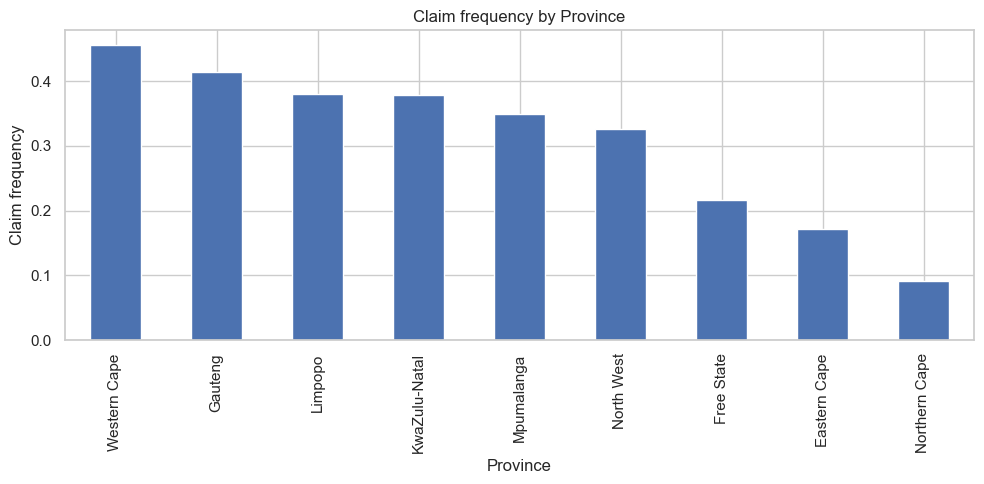

In [32]:
# Cell 4 — H0: There are no risk differences across provinces (Frequency)
if 'Province' not in combined.columns:
    print("Province column not present — skipping province frequency test.")
else:
    # build contingency: Province x ClaimEvent (0/1)
    ctab = pd.crosstab(combined['Province'], combined['ClaimEvent'])
    display(ctab)
    chi2, pchi, dof, expected = st.chi2_contingency(ctab)
    report_result("Province vs ClaimEvent (Chi-square)", chi2, pchi)

    # compute claim rates
    claim_rates = combined.groupby('Province')['ClaimEvent'].mean().sort_values(ascending=False)
    print("Claim rate by Province (descending):")
    display(claim_rates)
    # save barplot
    plt.figure(figsize=(10,5))
    claim_rates.plot(kind='bar')
    plt.ylabel("Claim frequency")
    plt.title("Claim frequency by Province")
    plt.tight_layout()
    plt.savefig("../reports/figures/claim_rate_by_province.png", dpi=150)
    plt.show()


In [33]:
# Cell 5 — H0: Severity differences across provinces (Kruskal-Wallis + post-hoc)
if 'Province' in combined.columns and 'Severity' in combined.columns:
    groups = [grp['Severity'].dropna().values for name, grp in combined.groupby('Province')]
    non_empty = [g for g in groups if len(g) > 0]
    if len(non_empty) < 2:
        print("Not enough severity data per province for testing.")
    else:
        kw_stat, kw_p = st.kruskal(*non_empty)
        report_result("Province vs Severity (Kruskal-Wallis)", kw_stat, kw_p)
        if kw_p < 0.05:
            provs = [name for name, grp in combined.groupby('Province')]
            if HAS_SP:
                arrays = [combined[combined['Province']==p]['Severity'].dropna().values for p in provs]
                dunn = sp.posthoc_dunn(arrays, p_adjust='bonferroni')
                dunn.index = provs; dunn.columns = provs
                print("Dunn post-hoc (Bonferroni adjusted p-values):")
                display(dunn)
                dunn.to_csv("../reports/figures/dunn_province_severity.csv")
            else:
                # pairwise Mann-Whitney (sampled) with bonferroni
                rows=[]
                for i,j in combinations(range(len(provs)),2):
                    g1 = combined[combined['Province']==provs[i]]['Severity'].dropna()
                    g2 = combined[combined['Province']==provs[j]]['Severity'].dropna()
                    if len(g1) > 2000: g1 = g1.sample(2000, random_state=42)
                    if len(g2) > 2000: g2 = g2.sample(2000, random_state=42)
                    stat, p = st.mannwhitneyu(g1, g2, alternative='two-sided')
                    rows.append((provs[i], provs[j], stat, p))
                posthoc = pd.DataFrame(rows, columns=['prov1','prov2','stat','pval'])
                posthoc['p_adj'] = multipletests(posthoc['pval'], method='bonferroni')[1]
                display(posthoc.sort_values('p_adj').head(40))
else:
    print("Province or Severity missing; skipping province severity test.")


=== Province vs Severity (Kruskal-Wallis) ===
statistic: 26682
p-value:   0
DECISION: REJECT H0

Dunn post-hoc (Bonferroni adjusted p-values):


,Eastern Cape,Free State,Gauteng,KwaZulu-Natal,Limpopo,Mpumalanga,North West,Northern Cape,Western Cape
Eastern Cape,1.000000e+00,8.896627e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.947331e-28,0.0
Free State,8.896627e-10,1.000000e+00,0.000000e+00,5.768744e-226,2.842833e-84,3.338257e-58,1.137765e-53,8.095741e-45,0.0
Gauteng,0.000000e+00,0.000000e+00,1.000000e+00,2.433838e-200,6.349850e-210,0.000000e+00,0.000000e+00,0.000000e+00,0.0
KwaZulu-Natal,0.000000e+00,5.768744e-226,2.433838e-200,1.000000e+00,9.401808e-63,2.779884e-258,0.000000e+00,0.000000e+00,0.0
Limpopo,0.000000e+00,2.842833e-84,6.349850e-210,9.401808e-63,1.000000e+00,6.561439e-12,2.004567e-24,4.331132e-266,0.0
Mpumalanga,0.000000e+00,3.338257e-58,0.000000e+00,2.779884e-258,6.561439e-12,1.000000e+00,6.922671e-02,1.752971e-233,0.0
North West,0.000000e+00,1.137765e-53,0.000000e+00,0.000000e+00,2.004567e-24,6.922671e-02,1.000000e+00,1.146911e-232,0.0
Northern Cape,3.947331e-28,8.095741e-45,0.000000e+00,0.000000e+00,4.331132e-266,1.752971e-233,1.146911e-232,1.000000e+00,0.0
Western Cape,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0


In [34]:
# Cell 6 — H0: No risk differences between zip codes (top-N approach)
top_n = 10
if 'PostalCode' not in combined.columns:
    print("PostalCode missing — skipping zip code tests.")
else:
    top_zips = combined['PostalCode'].value_counts().nlargest(top_n).index.tolist()
    print("Top zip codes:", top_zips)
    sub = combined[combined['PostalCode'].isin(top_zips)].copy()

    # Frequency (chi-square)
    ctab_zip = pd.crosstab(sub['PostalCode'], sub['ClaimEvent'])
    display(ctab_zip)
    chi2_zip, p_zip, dof_zip, exp = st.chi2_contingency(ctab_zip)
    report_result(f"Top {top_n} PostalCodes vs ClaimEvent (Chi-square)", chi2_zip, p_zip)

    # Severity (Kruskal)
    groups = [grp['Severity'].dropna().values for name, grp in sub.groupby('PostalCode')]
    non_empty = [g for g in groups if len(g) > 0]
    if len(non_empty) >= 2:
        kw_stat_z, kw_p_z = st.kruskal(*non_empty)
        report_result(f"Top {top_n} PostalCodes vs Severity (Kruskal-Wallis)", kw_stat_z, kw_p_z)
        if kw_p_z < 0.05:
            if HAS_SP:
                dunn = sp.posthoc_dunn(non_empty, p_adjust='bonferroni')
                zips = [name for name,_ in sub.groupby('PostalCode')]
                dunn.index = zips; dunn.columns = zips
                display(dunn)
            else:
                print("scikit-posthocs not available; skipping heavy post-hoc for PostalCodes.")
    else:
        print("Insufficient severity data across selected postal codes.")


Top zip codes: [2000.0, 122.0, 7784.0, 299.0, 7405.0, 458.0, 8000.0, 2196.0, 470.0, 7100.0]


ClaimEvent,0.0,1.0
PostalCode,,
122.0,29702,19469
299.0,15969,9577
458.0,10085,3690
470.0,5155,5071
2000.0,54672,78826
2196.0,6290,4758
7100.0,5883,4278
7405.0,2196,16322
7784.0,17498,11087


=== Top 10 PostalCodes vs ClaimEvent (Chi-square) ===
statistic: 26037.2
p-value:   0
DECISION: REJECT H0

=== Top 10 PostalCodes vs Severity (Kruskal-Wallis) ===
statistic: 54753.4
p-value:   0
DECISION: REJECT H0



,122.0,299.0,458.0,470.0,2000.0,2196.0,7100.0,7405.0,7784.0,8000.0
122.0,1.000000e+00,1.348538e-101,7.816131e-191,1.809623e-01,0.000000e+00,1.451837e-98,3.600913e-11,0.0,1.000000e+00,0.0
299.0,1.348538e-101,1.000000e+00,1.074205e-27,2.313775e-62,0.000000e+00,1.240340e-255,8.158915e-95,0.0,5.283502e-81,0.0
458.0,7.816131e-191,1.074205e-27,1.000000e+00,2.848201e-128,0.000000e+00,0.000000e+00,3.031061e-168,0.0,3.115666e-164,0.0
470.0,1.809623e-01,2.313775e-62,2.848201e-128,1.000000e+00,0.000000e+00,4.815628e-43,3.780222e-02,0.0,2.568743e-01,0.0
2000.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.226369e-150,0.000000e+00,0.0,0.000000e+00,0.0
2196.0,1.451837e-98,1.240340e-255,0.000000e+00,4.815628e-43,1.226369e-150,1.000000e+00,1.333482e-24,0.0,1.505417e-87,0.0
7100.0,3.600913e-11,8.158915e-95,3.031061e-168,3.780222e-02,0.000000e+00,1.333482e-24,1.000000e+00,0.0,4.473738e-10,0.0
7405.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.0
7784.0,1.000000e+00,5.283502e-81,3.115666e-164,2.568743e-01,0.000000e+00,1.505417e-87,4.473738e-10,0.0,1.000000e+00,0.0
8000.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.0


In [35]:
# Cell 7 — H0: No margin difference between zip codes (top-N)
if 'PostalCode' in combined.columns and 'Margin' in combined.columns:
    sub = combined[combined['PostalCode'].isin(top_zips)].copy()
    groups_m = [grp['Margin'].dropna().values for name, grp in sub.groupby('PostalCode')]
    non_empty_m = [g for g in groups_m if len(g) > 0]
    if len(non_empty_m) >= 2:
        kwm, kwpm = st.kruskal(*non_empty_m)
        report_result(f"Top {top_n} PostalCodes vs Margin (Kruskal-Wallis)", kwm, kwpm)
        if kwpm < 0.05 and HAS_SP:
            dunnm = sp.posthoc_dunn(non_empty_m, p_adjust='bonferroni')
            zips = [name for name,_ in sub.groupby('PostalCode')]
            dunnm.index = zips; dunnm.columns = zips
            display(dunnm)
    else:
        print("Insufficient margin data across selected postal codes.")
else:
    print("PostalCode or Margin missing -> cannot test margin by zip code.")


=== Top 10 PostalCodes vs Margin (Kruskal-Wallis) ===
statistic: 36093.2
p-value:   0
DECISION: REJECT H0



,122.0,299.0,458.0,470.0,2000.0,2196.0,7100.0,7405.0,7784.0,8000.0
122.0,1.000000e+00,0.000000e+00,1.803445e-115,5.032997e-28,6.770826e-04,8.694097e-24,8.113998e-55,0.0,0.000000e+00,1.000000e+00
299.0,0.000000e+00,1.000000e+00,3.536234e-49,1.595265e-105,0.000000e+00,0.000000e+00,1.502352e-68,0.0,3.171644e-29,1.261844e-253
458.0,1.803445e-115,3.536234e-49,1.000000e+00,1.673362e-12,7.590539e-108,6.469881e-147,7.498132e-03,0.0,5.655097e-07,4.590725e-68
470.0,5.032997e-28,1.595265e-105,1.673362e-12,1.000000e+00,7.573601e-21,7.456808e-63,1.801100e-02,0.0,4.605550e-41,5.182739e-18
2000.0,6.770826e-04,0.000000e+00,7.590539e-108,7.573601e-21,1.000000e+00,3.025425e-39,2.679282e-46,0.0,0.000000e+00,8.705625e-01
2196.0,8.694097e-24,0.000000e+00,6.469881e-147,7.456808e-63,3.025425e-39,1.000000e+00,4.421669e-92,0.0,1.162390e-264,4.078647e-15
7100.0,8.113998e-55,1.502352e-68,7.498132e-03,1.801100e-02,2.679282e-46,4.421669e-92,1.000000e+00,0.0,3.138553e-19,2.022538e-35
7405.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00
7784.0,0.000000e+00,3.171644e-29,5.655097e-07,4.605550e-41,0.000000e+00,1.162390e-264,3.138553e-19,0.0,1.000000e+00,3.472990e-143
8000.0,1.000000e+00,1.261844e-253,4.590725e-68,5.182739e-18,8.705625e-01,4.078647e-15,2.022538e-35,0.0,3.472990e-143,1.000000e+00


In [36]:
# Cell 8 — H0: No significant risk difference between Women and Men
# Frequency: proportion z-test; Severity: t-test + Mann-Whitney
claim_col = next((c for c in ['ClaimEvent','ClaimEvent_x','ClaimEvent_y'] if c in combined.columns), 'ClaimEvent')
sev_col = next((c for c in ['Severity','Severity_x','Severity_y'] if c in combined.columns), 'Severity')

if 'Gender' not in combined.columns:
    print("Gender missing -> skipping gender tests.")
else:
    dfg = combined.copy()
    dfg['Gender'] = dfg['Gender'].astype(str).str.upper().str.strip()
    male_mask = dfg['Gender'].str.contains('^M')
    female_mask = dfg['Gender'].str.contains('^F')
    males = dfg[male_mask]; females = dfg[female_mask]
    print("N males:", len(males), "N females:", len(females))

    # Frequency (proportion test)
    count = np.array([males[claim_col].sum(), females[claim_col].sum()])
    nobs = np.array([len(males), len(females)])
    stat_gf, p_gf = proportions_ztest(count, nobs)
    report_result("Gender vs Claim Frequency (Proportion Z-Test)", stat_gf, p_gf)

    # Severity
    sev_m = males[sev_col].dropna(); sev_f = females[sev_col].dropna()
    if len(sev_m) >= 10 and len(sev_f) >= 10:
        lev = st.levene(sev_m, sev_f)
        equal_var = lev.pvalue > 0.05
        tstat, tp = st.ttest_ind(sev_m, sev_f, equal_var=equal_var)
        mw = st.mannwhitneyu(sev_m, sev_f, alternative='two-sided')
        report_result("Gender vs Severity (t-test)", tstat, tp)
        report_result("Gender vs Severity (Mann-Whitney)", mw.statistic, mw.pvalue)
    else:
        print("Not enough severity samples for gender severity tests.")


N males: 42817 N females: 6755
=== Gender vs Claim Frequency (Proportion Z-Test) ===
statistic: -22.401
p-value:   3.84505e-111
DECISION: REJECT H0

=== Gender vs Severity (t-test) ===
statistic: -4.88058
p-value:   1.07232e-06
DECISION: REJECT H0

=== Gender vs Severity (Mann-Whitney) ===
statistic: 1.26399e+08
p-value:   5.8144e-89
DECISION: REJECT H0



In [37]:
# Cell 9 — Multiple testing control across recorded p-values (optional)
# This applies an FDR correction across all tests collected.
if len(TEST_RESULTS) > 0:
    results_df = pd.DataFrame.from_dict(TEST_RESULTS, orient='index')
    pvals = results_df['p'].astype(float).values
    reject, pvals_corrected, _, _ = multipletests(pvals, method='fdr_bh')
    results_df['p_adj_fdr'] = pvals_corrected
    results_df['reject_fdr'] = reject
    display(results_df.sort_values('p'))
    # overwrite TEST_RESULTS with adjusted p-values for consistency
    for i, name in enumerate(results_df.index):
        TEST_RESULTS[name]['p_adj_fdr'] = float(results_df.loc[name, 'p_adj_fdr'])
        TEST_RESULTS[name]['reject_fdr'] = bool(results_df.loc[name, 'reject_fdr'])
else:
    print("No tests recorded in TEST_RESULTS (possible bug).")


,stat,p,p_adj_fdr,reject_fdr
Province vs ClaimEvent (Chi-square),1.649036e+04,0.000000e+00,0.000000e+00,True
Province vs Severity (Kruskal-Wallis),2.668202e+04,0.000000e+00,0.000000e+00,True
Top 10 PostalCodes vs ClaimEvent (Chi-square),2.603720e+04,0.000000e+00,0.000000e+00,True
Top 10 PostalCodes vs Severity (Kruskal-Wallis),5.475342e+04,0.000000e+00,0.000000e+00,True
Top 10 PostalCodes vs Margin (Kruskal-Wallis),3.609325e+04,0.000000e+00,0.000000e+00,True
Gender vs Claim Frequency (Proportion Z-Test),-2.240104e+01,3.845049e-111,5.126732e-111,True
Gender vs Severity (Mann-Whitney),1.263991e+08,5.814395e-89,6.645023e-89,True
Gender vs Severity (t-test),-4.880584e+00,1.072323e-06,1.072323e-06,True


Saved hypothesis_test_summary.csv (reports/hypothesis_test_summary.csv)


,stat,p,p_adj_fdr,reject_fdr
Test,,,,
Province vs ClaimEvent (Chi-square),1.649036e+04,0.000000e+00,0.000000e+00,True
Province vs Severity (Kruskal-Wallis),2.668202e+04,0.000000e+00,0.000000e+00,True
Top 10 PostalCodes vs ClaimEvent (Chi-square),2.603720e+04,0.000000e+00,0.000000e+00,True
Top 10 PostalCodes vs Severity (Kruskal-Wallis),5.475342e+04,0.000000e+00,0.000000e+00,True
Top 10 PostalCodes vs Margin (Kruskal-Wallis),3.609325e+04,0.000000e+00,0.000000e+00,True
Gender vs Claim Frequency (Proportion Z-Test),-2.240104e+01,3.845049e-111,5.126732e-111,True
Gender vs Severity (t-test),-4.880584e+00,1.072323e-06,1.072323e-06,True
Gender vs Severity (Mann-Whitney),1.263991e+08,5.814395e-89,6.645023e-89,True


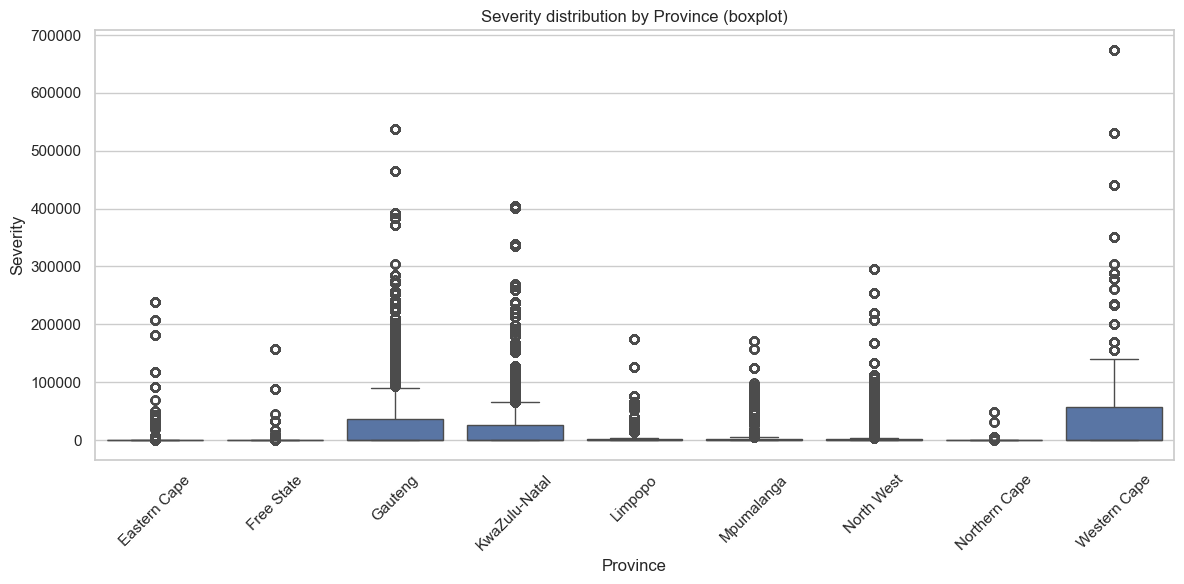

\n--- Executive summary template (fill values from summary_df) ---\n
Business objective: Identify low-risk segments for premium reduction while ensuring profitability.

Key statistical outcomes (examples, replace with exact numbers):
- Province vs ClaimEvent (Chi-square): stat=16490.4, p=0, p_adj_fdr=0
- Province vs Severity (Kruskal-Wallis): stat=26682, p=0, p_adj_fdr=0
- Top 10 PostalCodes vs ClaimEvent (Chi-square): stat=26037.2, p=0, p_adj_fdr=0
- Top 10 PostalCodes vs Severity (Kruskal-Wallis): stat=54753.4, p=0, p_adj_fdr=0
- Top 10 PostalCodes vs Margin (Kruskal-Wallis): stat=36093.2, p=0, p_adj_fdr=0
- Gender vs Claim Frequency (Proportion Z-Test): stat=-22.401, p=3.84505e-111, p_adj_fdr=5.12673e-111
- Gender vs Severity (t-test): stat=-4.88058, p=1.07232e-06, p_adj_fdr=1.07232e-06
- Gender vs Severity (Mann-Whitney): stat=1.26399e+08, p=5.8144e-89, p_adj_fdr=6.64502e-89

Interpretation / recommended actions (template):
- If test rejected H0 for provinces (p < 0.05): consider p

In [38]:
# Cell 10 — Save outputs & quick executive summary template
summary_df = pd.DataFrame.from_dict(TEST_RESULTS, orient='index')
summary_df.index.name = 'Test'
summary_df.to_csv("../reports/hypothesis_test_summary.csv")
print("Saved hypothesis_test_summary.csv (reports/hypothesis_test_summary.csv)")
display(summary_df)

# Save a couple of quick plots
# Claim rate map-like bar already saved earlier. Save a boxplot for provinces severity:
if 'Province' in combined.columns and 'Severity' in combined.columns:
    plt.figure(figsize=(12,6))
    order = combined.groupby('Province')['Severity'].median().sort_values(ascending=False).index
    sns.boxplot(x='Province', y='Severity', data=combined, order=order)
    plt.xticks(rotation=45)
    plt.title('Severity distribution by Province (boxplot)')
    plt.tight_layout()
    plt.savefig('../reports/figures/severity_by_province_boxplot.png', dpi=150)
    plt.show()

print("\\n--- Executive summary template (fill values from summary_df) ---\\n")
print("Business objective: Identify low-risk segments for premium reduction while ensuring profitability.")
print("")
print("Key statistical outcomes (examples, replace with exact numbers):")
for name, row in summary_df.iterrows():
    print(f"- {name}: stat={row.get('stat'):.6g}, p={row.get('p'):.6g}", end='')
    if 'p_adj_fdr' in row:
        print(f", p_adj_fdr={row.get('p_adj_fdr'):.6g}", end='')
    print()
print("")
print("Interpretation / recommended actions (template):")
print("- If test rejected H0 for provinces (p < 0.05): consider province-level loading factors or targeted underwriting rules.")
print("- If test rejected H0 for postal codes: consider targeted pricing or underwriting (telemetry, higher excess).")
print("- If gender tests show difference: confirm regulatory permissibility before using gender as rating factor; otherwise find lawful correlated features (driving history, claims-free years).")
print("- If margin differs across zip codes: consider repricing or product changes in those zip codes.")
